Use the GOES-R [Clear Sky Mask](https://www.goes-r.gov/products/baseline-clear-sky-mask.html).

Code mentioned in this question: https://stackoverflow.com/questions/70535067/using-cartopy-to-project-geostationary-data-points-onto-a-regular-grid?rq=3

In [ ]:
%%capture
!pip install goes2go
# !apt-get -V -y -qq install python-cartopy python3-cartopy
!pip uninstall shapely -y
!pip install shapely --no-binary shapely
!pip install cartopy

In [3]:
%%capture
!pip install goes2go

In [1]:
import cartopy.crs as ccrs

In [4]:
%matplotlib inline
import numpy as np
from datetime import datetime, timedelta
import xarray
import matplotlib.pyplot as plt
from goes2go.data import goes_latest, goes_nearesttime, goes_timerange

 ╭─────────────────────────────────────────────────╮
 │ I'm building goes2go's default config file.     │
 ╰╥────────────────────────────────────────────────╯
 👷🏻‍♂️
⚙ Created config file [/home/ebezerra/.config/goes2go/config.toml] with default values.


In [5]:
time = '2021-01-01 20:00'
T = goes_nearesttime(time, satellite='G16', product='ABI', return_as='xarray')

# https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C01503
C = goes_nearesttime(time, satellite='G16', product='ABI-L2-ACMC', return_as='xarray')

📦 Finished downloading [1] files to [/home/ebezerra/data/noaa-goes16/ABI-L2-MCMIPC].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [6]:
C['BCM'].data.shape

(1500, 2500)

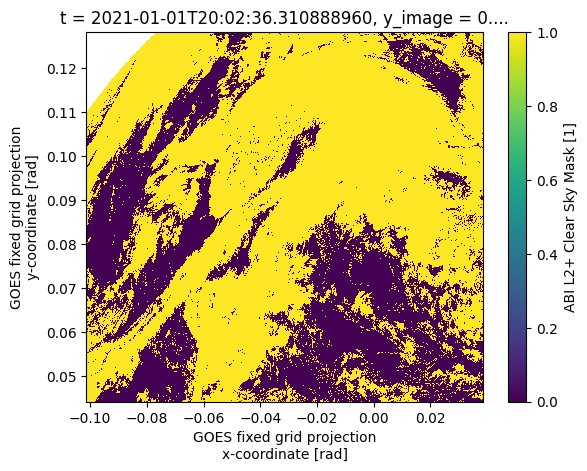

In [7]:
C['BCM'].plot()

In [ ]:
C['BCM'].dims

('y', 'x')

In [ ]:
C.BCM.data

array([[nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  1., ...,  0.,  0.,  0.]], dtype=float32)

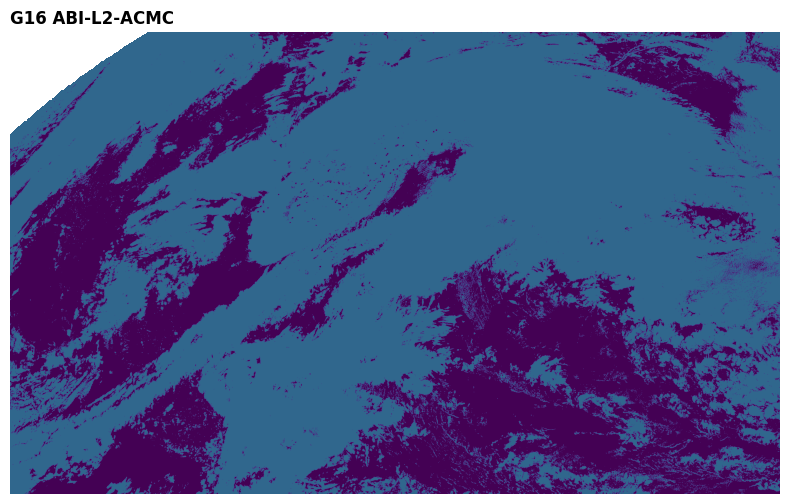

In [8]:
fig, (ax1) = plt.subplots(1,1, figsize=(16,6))

ax1.imshow(C['BCM'], vmin=0, vmax=3)
ax1.set_title('G16 ABI-L2-ACMC', fontweight='semibold', loc='left', fontsize=12);
ax1.axis('off');

In [9]:
sat_h = C['goes_imager_projection'].perspective_point_height # 35786023.0
sat_lon = C['goes_imager_projection'].longitude_of_projection_origin # -75.0
sat_sweep = C['goes_imager_projection'].sweep_angle_axis # 'x'
semi_major = C['goes_imager_projection'].semi_major_axis # 6378137.0
semi_minor = C['goes_imager_projection'].semi_minor_axis # 6356752.31414

In [10]:
# The projection x and y coordinates equals the scanning angle (in radians)
# multiplied by the satellite height See details here:
# https://proj4.org/operations/projections/geos.html?highlight=geostationary
x = C['x'][:] * sat_h
y = C['y'][:] * sat_h

globe = ccrs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor)
geos = ccrs.Geostationary(central_longitude=sat_lon, satellite_height=sat_h, globe=globe)

# Use a Lambert Conformal projection
lc = ccrs.LambertConformal(central_longitude=-97.5, standard_parallels=(38.5,38.5))

/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/ebezerra/anaconda3/envs/atmoseer/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


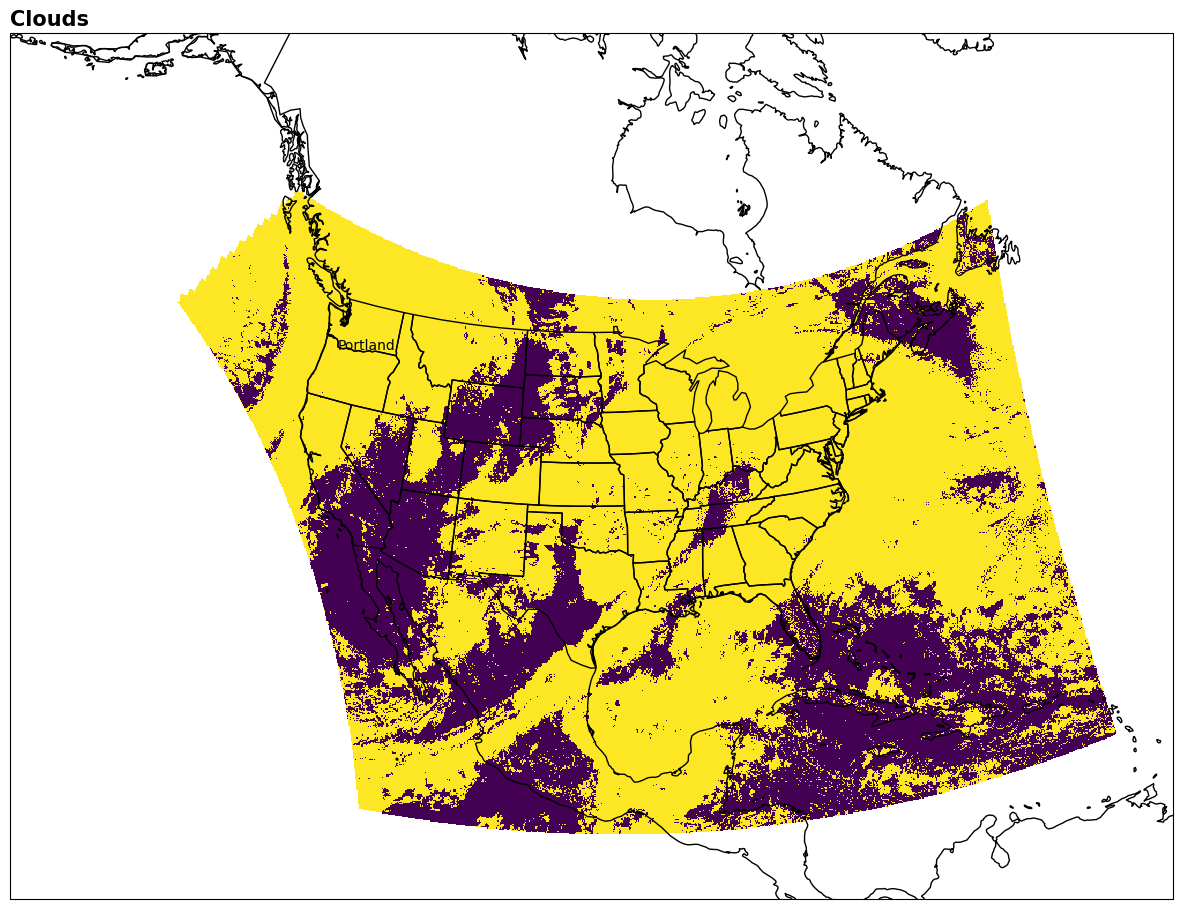

In [11]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(1, 1, 1, projection=lc)
ax.set_extent([-135, -60, 10, 65], crs=ccrs.PlateCarree())
ax.imshow(np.flipud(C['BCM']), origin='lower',
                   extent=(x.min(), x.max(), y.min(), y.max()),
                   transform=geos,
                   interpolation='none')
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.add_feature(ccrs.cartopy.feature.STATES)
ax.text(-122.6, 45.5, 'Portland', transform=ccrs.PlateCarree())

plt.title('Clouds', loc='left', fontweight='semibold', fontsize=15)
fig.show()

In [12]:
mojave_location={'latitude':35.00, 'longitude':-115.4749981}
location_geos = geos.transform_point(mojave_location['longitude'], mojave_location['latitude'], ccrs.PlateCarree()) / sat_h

# Cloud cover at this location
C['BCM'].sel(y=location_geos[1],x=location_geos[0],method='nearest').values

array(0., dtype=float32)

In [13]:
portland_location={'latitude': 45.5, 'longitude':-122.6}
location_geos = geos.transform_point(portland_location['longitude'], portland_location['latitude'], ccrs.PlateCarree()) / sat_h

# Cloud cover at this location
C['BCM'].sel(y=location_geos[1],x=location_geos[0],method='nearest').values

array(1., dtype=float32)

In [14]:
us_bbox = [(-124.848974, 24.396308), (-66.885444, 49.384358)]
width_longitude = us_bbox[1][0] - us_bbox[0][0]
width_latitude = us_bbox[1][1] - us_bbox[0][1]
[width_longitude, width_latitude]

[57.96352999999999, 24.988049999999998]

In [15]:
grid_width = 500
grid_height = 500
grid = np.zeros((grid_width, grid_height))

for x in range(0, grid_width):
  for y in range(0, grid_height):
    location_geos = geos.transform_point(us_bbox[0][0] + x, us_bbox[0][1] + y, ccrs.PlateCarree()) / sat_h
    if not np.any(np.isnan(location_geos)):
      grid[(x, y)] = C['BCM'].sel(y=location_geos[1],x=location_geos[0],method='nearest').values

grid

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

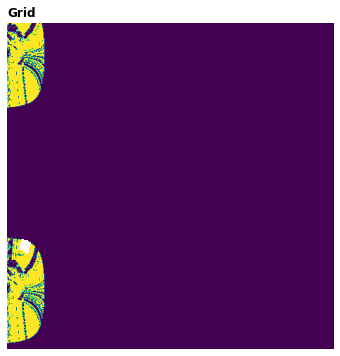

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(16,6))

# The RGB using the raw veggie band
ax1.imshow(grid, vmin=0, vmax=1)
ax1.set_title('Grid', fontweight='semibold', loc='left', fontsize=12);
ax1.axis('off');